In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt

In [2]:
np.random.seed(11)
tf.random.set_seed(11)
batch_size = 256
max_epochs = 10
learning_rate = 1e-3
momentum = 8e-1
hidden_dim = 128
original_dim = 784

In [3]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))

training_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

In [5]:
class Encoder(K.layers.Layer):
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = K.layers.Dense(units=hidden_dim, activation=tf.nn.relu)
        
    
    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return activation

In [6]:
class Decoder(K.layers.Layer):
    def __init__(self, hidden_dim, original_dim):
        super(Decoder, self).__init__()
        self.output_layer = K.layers.Dense(units=original_dim, activation=tf.nn.relu)
  
    def call(self, encoded):
        activation = self.output_layer(encoded)
        return activation

In [7]:
class Autoencoder(K.Model):
    def __init__(self, hidden_dim, original_dim):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(hidden_dim=hidden_dim)
        self.decoder = Decoder(hidden_dim=hidden_dim, original_dim=original_dim)

    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed = self.decoder(encoded)
        return reconstructed

In [8]:
autoencoder = Autoencoder(hidden_dim=hidden_dim, original_dim=original_dim)
opt = tf.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
def loss(preds, real):
    return tf.reduce_mean(tf.square(tf.subtract(preds, real)))

def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        preds = model(original)
        reconstruction_error = loss(preds, original)
    gradients = tape.gradient(reconstruction_error, model.trainable_variables)
    gradient_variables = zip(gradients, model.trainable_variables)
    opt.apply_gradients(gradient_variables)
  
    return reconstruction_error

In [9]:
def train_loop(model, opt, loss, dataset, epochs=20):
    for epoch in range(epochs):
        epoch_loss = 0
        for step, batch_features in enumerate(dataset):
            loss_values = train(loss, model, opt, batch_features)
            epoch_loss += loss_values
        model.loss.append(epoch_loss)
        print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, epoch_loss.numpy()))

In [10]:
autoencoder = Autoencoder(hidden_dim=hidden_dim, original_dim=original_dim)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(autoencoder, opt, loss, training_dataset, epochs=max_epochs)

Epoch 1/10. Loss: 4.9282121658325195
Epoch 2/10. Loss: 2.896676778793335
Epoch 3/10. Loss: 2.7423431873321533
Epoch 4/10. Loss: 2.658803939819336
Epoch 5/10. Loss: 2.60323166847229
Epoch 6/10. Loss: 2.5582902431488037
Epoch 7/10. Loss: 2.58246111869812
Epoch 8/10. Loss: 2.509129285812378
Epoch 9/10. Loss: 2.503899574279785
Epoch 10/10. Loss: 2.489875078201294


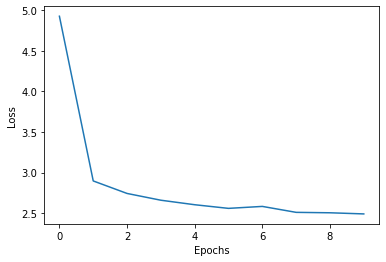

In [11]:
plt.plot(range(max_epochs), autoencoder.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

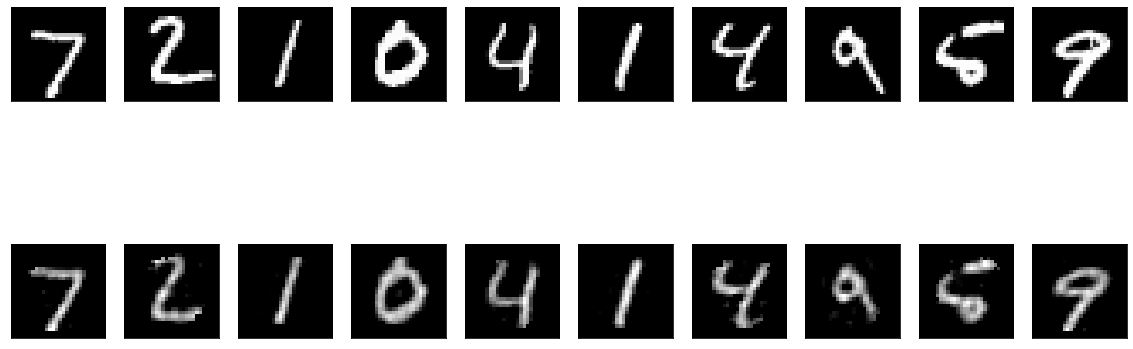

In [12]:
number = 10
plt.figure(figsize = (20, 8))
for index in range(number):
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(autoencoder(x_test)[index].numpy().reshape(28, 28), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# SEQUENTIAL MODEL

In [13]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(input_shape = [784,], units = 128, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(units = 784, activation = tf.nn.relu))

model.compile(loss = 'mean_squared_error', optimizer = 'adam')#tf.compat.v1.train.AdamOptimizer())

In [14]:
history = model.fit(x = x_train, y = x_train, epochs = 10, batch_size = 256, verbose = 1)

Epoch 1/10
235/235 [==============================] - 6s 27ms/step - loss: 0.0266
Epoch 2/10
235/235 [==============================] - 6s 27ms/step - loss: 0.0095
Epoch 3/10
235/235 [==============================] - 7s 31ms/step - loss: 0.0078
Epoch 4/10
235/235 [==============================] - 7s 31ms/step - loss: 0.0070
Epoch 5/10
235/235 [==============================] - 6s 26ms/step - loss: 0.0066
Epoch 6/10
235/235 [==============================] - 7s 30ms/step - loss: 0.0063
Epoch 7/10
235/235 [==============================] - 6s 27ms/step - loss: 0.0061
Epoch 8/10
235/235 [==============================] - 6s 27ms/step - loss: 0.0060
Epoch 9/10
235/235 [==============================] - 6s 27ms/step - loss: 0.0059
Epoch 10/10
235/235 [==============================] - 7s 29ms/step - loss: 0.0058


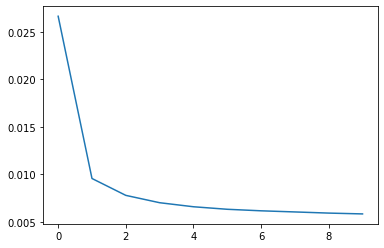

In [15]:
plt.plot(history.history['loss'])

In [16]:
reconstructed_images = model.predict(x_test)

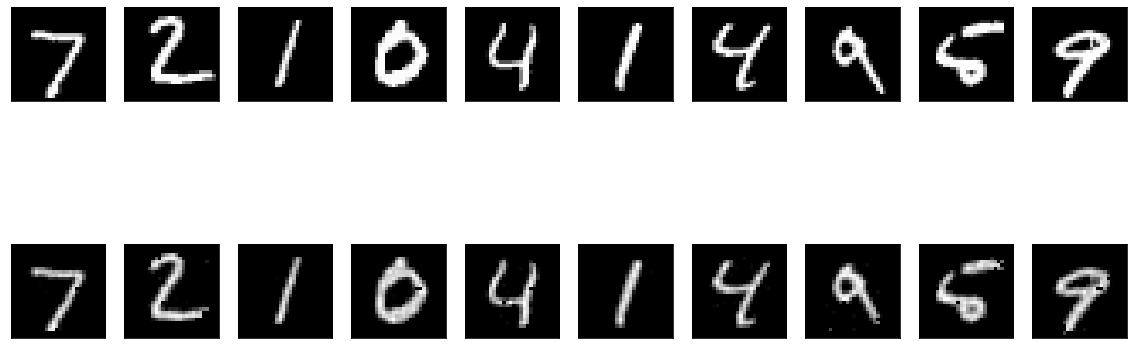

In [22]:
plt.figure(figsize = (20, 8))
number = 10
for index in range(number):
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(reconstructed_images[index].reshape(28, 28), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()